In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import time
import pandas as pd

mingw_bin = "C:/msys64/mingw64/bin"
os.add_dll_directory(mingw_bin)
import ctypes
lin = ctypes.cdll.LoadLibrary("./cmake-build-release/liblinear_model.dll")

lin.create_linear_model.argtypes = [ctypes.c_int32]
lin.create_linear_model.restype = ctypes.c_void_p

lin.predict_linear_model.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_float)]
lin.predict_linear_model.restype = ctypes.c_float

lin.release_linear_model.argtypes = [ctypes.c_void_p]
lin.release_linear_model.restype = None

lin.train_linear_model.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_float), ctypes.POINTER(ctypes.c_float), ctypes.c_int32, ctypes.c_float, ctypes.c_int32]
lin.train_linear_model.restype = None

lin.create_ovo_classifier.argtypes = [ctypes.c_int32]
lin.create_ovo_classifier.restype = ctypes.c_void_p

lin.train_ovo_classifier.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_float), ctypes.POINTER(ctypes.c_int32), ctypes.c_int32, ctypes.c_int32, ctypes.c_float]
lin.train_ovo_classifier.restype = None

lin.predict_ovo_classifier.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_float)]
lin.predict_ovo_classifier.restype = ctypes.c_int32

lin.release_ovo_classifier.argtypes = [ctypes.c_void_p]
lin.release_ovo_classifier.restype = None

mlp = ctypes.cdll.LoadLibrary("./cmake-build-release/libmlp.dll") 

mlp.create_mlp_model.argtypes = [ctypes.POINTER(ctypes.c_int), ctypes.c_int, ctypes.c_int]
mlp.create_mlp_model.restype = ctypes.c_void_p

mlp.train_mlp_model.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int,
    ctypes.c_int,
    ctypes.c_float,
    ctypes.c_int,
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int,
    ctypes.c_char_p
]
mlp.predict_mlp_model.restype = ctypes.POINTER(ctypes.c_float)

mlp.predict_mlp_model.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_float),
]

mlp.release_mlp_model.argtypes = [ctypes.c_void_p]

mlp.get_confusion_matrix.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_int32)]
mlp.get_confusion_matrix.restype = None

mlp.evaluate_confusion_matrix.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int
]
mlp.evaluate_confusion_matrix.restype = None

mlp.save_mlp_model.argtypes = [ctypes.c_void_p, ctypes.c_char_p]

mlp.load_mlp_model.argtypes = [ctypes.c_char_p]
mlp.load_mlp_model.restype = ctypes.c_void_p


LOG_FUNC_TYPE = ctypes.CFUNCTYPE(None, ctypes.c_char_p)

@LOG_FUNC_TYPE
def logger_callback(msg):
    print(msg.decode())

In [3]:
classnames_array = ['Crocodile', 'Elephant', 'Gorille']
size = 16

### Organisation du Dataset pour l'entrainement

In [8]:
data = []
folder_path = './images16/'
for classname in os.listdir(folder_path):  
    for filename in os.listdir(folder_path + classname):
        img = Image.open(folder_path + classname + '/' + filename)
        index = classnames_array.index(classname)  
        
        one_hot = np.zeros(len(classnames_array), dtype=np.float32)
        one_hot[index] = 1.0
        
        img_array = (np.array(img) / 255.0)
        data.append([one_hot, img_array])

data = np.array(data, dtype=object)
print(data)




[[array([1., 0., 0.], dtype=float32)
  array([[[0.53333333, 0.30980392, 0.24313725],
          [0.55294118, 0.33333333, 0.26666667],
          [0.50980392, 0.29411765, 0.21568627],
          [0.39215686, 0.19215686, 0.10980392],
          [0.39607843, 0.19607843, 0.11372549],
          [0.54901961, 0.36078431, 0.2745098 ],
          [0.63529412, 0.45490196, 0.36470588],
          [0.57254902, 0.39215686, 0.30196078],
          [0.29803922, 0.11764706, 0.02352941],
          [0.26666667, 0.08627451, 0.        ],
          [0.2627451 , 0.08235294, 0.        ],
          [0.23921569, 0.05882353, 0.        ],
          [0.27843137, 0.08235294, 0.        ],
          [0.30588235, 0.10980392, 0.01176471],
          [0.35294118, 0.14901961, 0.05490196],
          [0.5254902 , 0.32156863, 0.22745098]],

         [[0.34509804, 0.16862745, 0.09411765],
          [0.38823529, 0.21176471, 0.1372549 ],
          [0.44313725, 0.27843137, 0.19215686],
          [0.40784314, 0.24313725, 0.15686275],
 

### Test avec MLP

Epoch 10: train_acc = 34.38%, train_loss = 3.3192 | test_acc = 29.48%, test_loss = 3.1967
Epoch 20: train_acc = 37.50%, train_loss = 3.2357 | test_acc = 30.09%, test_loss = 3.3254
Epoch 30: train_acc = 21.88%, train_loss = 2.4699 | test_acc = 28.27%, test_loss = 2.6420
Epoch 40: train_acc = 25.00%, train_loss = 2.1808 | test_acc = 22.80%, test_loss = 2.5476
Epoch 50: train_acc = 53.12%, train_loss = 2.2080 | test_acc = 27.36%, test_loss = 2.5265
Epoch 60: train_acc = 34.38%, train_loss = 2.2584 | test_acc = 23.71%, test_loss = 2.5779
Epoch 70: train_acc = 34.38%, train_loss = 2.4599 | test_acc = 26.75%, test_loss = 2.3727
Epoch 80: train_acc = 43.75%, train_loss = 2.0902 | test_acc = 25.53%, test_loss = 2.4219
Epoch 90: train_acc = 28.12%, train_loss = 2.1471 | test_acc = 27.36%, test_loss = 2.4146
Epoch 100: train_acc = 37.50%, train_loss = 1.9507 | test_acc = 26.14%, test_loss = 2.3928
Epoch 110: train_acc = 31.25%, train_loss = 2.0308 | test_acc = 29.79%, test_loss = 2.3577
Epoch 12

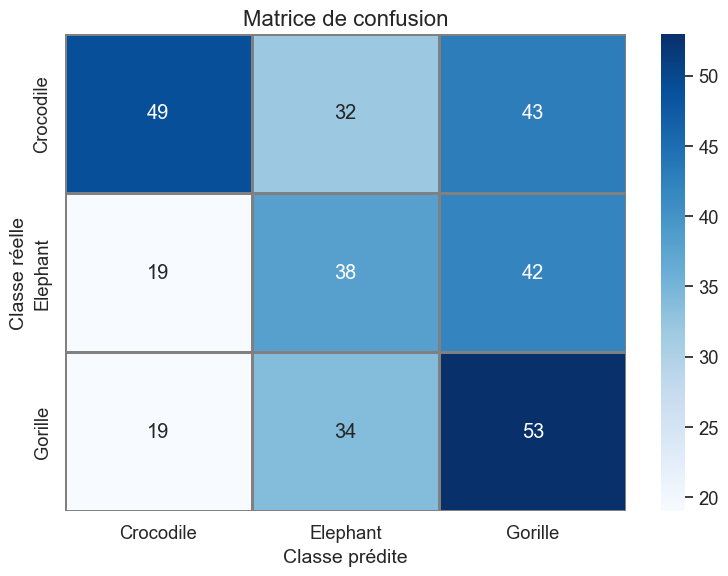

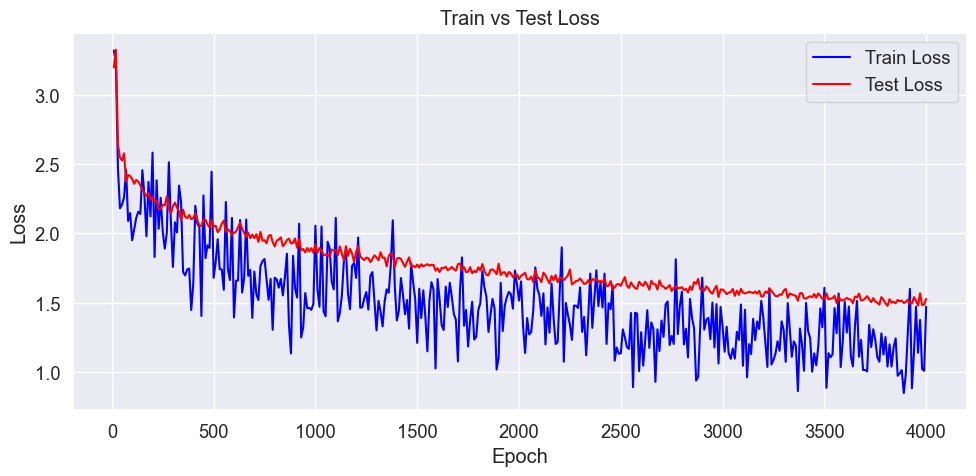

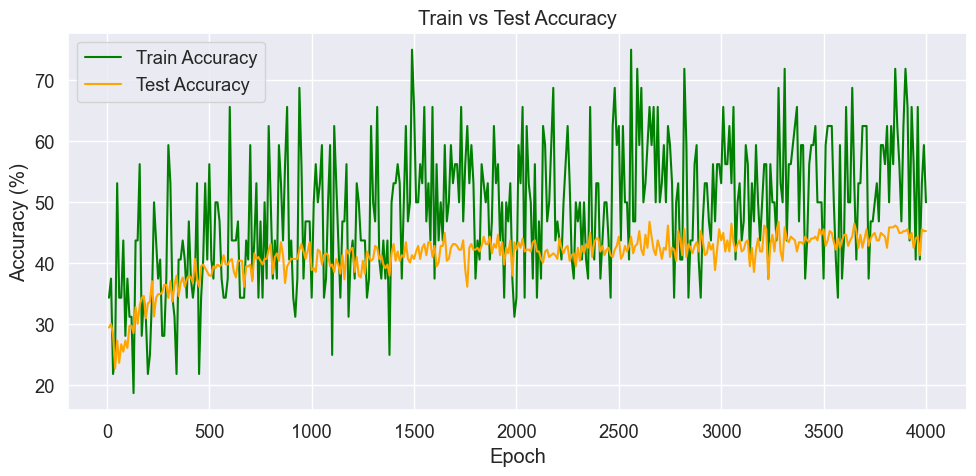

In [ ]:
layer_sizes = [size*size*3, 256, 128, len(classnames_array)]
layer_array = (ctypes.c_int * len(layer_sizes))(*layer_sizes)
model = mlp.create_mlp_model(layer_array, len(layer_sizes) - 1, 23)
mlp.set_logger(logger_callback)

np.random.shuffle(data)
split_index = int(len(data) * 0.8)
data_train = data[:split_index]
data_test = data[split_index:]
X_train = np.array([item[1] for item in data_train], dtype=np.float32)
Y_train = np.array([item[0] for item in data_train], dtype=np.float32)
X_test = np.array([item[1] for item in data_test], dtype=np.float32)
Y_test = np.array([item[0] for item in data_test], dtype=np.float32)

X_train_reshaped = X_train.reshape((X_train.shape[0], -1))
X_train_c = X_train_reshaped.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
Y_train_c = Y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
X_test_reshaped = X_test.reshape((X_test.shape[0], -1))
X_test_c = X_test_reshaped.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
Y_test_c = Y_test.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

epochs = 4000
learning_rate = 0.005
batch_size = 32
csv_path = "log2.csv"
with open(csv_path, "w") as csvfile:
        csvfile.truncate()
        csvfile.write("epoch,train_acc,train_loss,test_acc,test_loss\n")
time.sleep(0.2)

mlp.train_mlp_model(model, X_train_c, Y_train_c, len(data_train), epochs, learning_rate, batch_size, X_test_c, Y_test_c, len(data_test), csv_path.encode())

output_dim = len(classnames_array)
matrix = (ctypes.c_int * (output_dim * output_dim))()
mlp.evaluate_confusion_matrix(model, X_test_c, Y_test_c, len(data_test), True)
mlp.get_confusion_matrix(model, matrix)

confusion_np = np.ctypeslib.as_array(matrix).reshape((output_dim, output_dim))
print(confusion_np)
import seaborn as sns


plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
ax = sns.heatmap(confusion_np, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=classnames_array, yticklabels=classnames_array,
                 linewidths=1, linecolor='gray', cbar=True)

plt.title("Matrice de confusion", fontsize=16)
plt.xlabel("Classe prédite", fontsize=14)
plt.ylabel("Classe réelle", fontsize=14)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

df = pd.read_csv("log2.csv")

plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['test_loss'], label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', color='green')
plt.plot(df['epoch'], df['test_acc'], label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#mlp.release_mlp_model(model)

OSError: exception: access violation reading 0xFFFFFFFFFFFFFFFF

In [ ]:
mlp.save_mlp_model(model, b"mlp_trained.bin")

-201418088

In [ ]:
model_loaded = mlp.load_mlp_model(b"mlp_trained.bin")

OSError: [WinError -1073741569] Windows Error 0xc00000ff

In [ ]:
img = Image.open('C:/Users/lgrdp/Downloads/images (10).jpeg').convert("RGB")
img = img.resize(size=(32,32))
img_data = np.array(img) / 255.0

output_array = mlp.predict_mlp_model(model, img_data.ctypes.data_as(ctypes.POINTER(ctypes.c_float)), True)
output_array = ctypes.cast(output_array, ctypes.POINTER(ctypes.c_float * len(classnames_array))).contents
output = list(output_array)
class_index = 0
for i in range(len(output)):
    if output[i] == max(output):
        class_index = i
print('predicted class : ' + classnames_array[class_index])
print(output)


predicted class : zebre
[0.956343948841095, 0.983494222164154, 0.9977808594703674]
